In [1]:
import itertools

import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from ase.io import read as read_xyz, write as write_xyz
from ase.visualize import view
from ase.constraints import FixAtoms
from dscribe.descriptors import SOAP
from astartes import train_test_split

from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

## Data Loading

In [2]:
df = pd.read_csv("../data/gold-features.csv")
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,file_name,energy
0,8.312640,0.013240,0.002026,0.000578,0.000059,0.000005,3.614525e-07,2.891632e-08,3.363042e-09,9.584413e-11,0.xyz,-1547.657785
1,8.903285,0.026071,0.002458,0.000283,0.000031,0.000006,1.041832e-06,4.556548e-08,2.465568e-09,8.548989e-11,1.xyz,-1552.612539
2,9.287031,0.033807,0.002167,0.000183,0.000028,0.000006,1.474569e-06,6.771517e-08,1.839670e-09,8.525103e-11,10.xyz,-1555.417784
3,8.923366,0.023786,0.001960,0.000339,0.000035,0.000007,9.650267e-07,5.893078e-08,2.394213e-09,1.202439e-10,100.xyz,-1552.217633
4,9.086140,0.026782,0.001243,0.000245,0.000049,0.000005,1.253184e-06,4.471700e-08,3.935182e-09,1.254421e-10,101.xyz,-1552.886542


In [3]:
structures = [read_xyz(f"../data/raw/{x}") for x in df["file_name"]]
len(structures)

999

In [4]:
X = df.iloc[:, :10].values
y = df["energy"].values

X.shape, y.shape

((999, 10), (999,))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, sampler="kennard_stone", train_size=0.80, random_state=21)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((799, 10), (200, 10), (799,), (200,))

## Model

In [6]:
model = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("pca", PCA(n_components=6)),
    ("reg", XGBRegressor(
        random_state=21,
        booster="gbtree",
        tree_method="exact",
        n_estimators=100,
        max_depth=  4,
        eta=0.1136823210285093,
        reg_alpha=0.06671740722713554,
        reg_lambda=.010881414799327853,
        colsample_bytree=0.9702171387228603,
        subsample=0.7179234799654054,
    )),
])

model.fit(X_train, y_train)

,steps,"[('scale', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,6
,copy,True
,whiten,False
,svd_solver,'auto'


In [7]:
y_preds = model.predict(X_test)

print("MAE", mean_absolute_error(y_test, y_preds))
print("RMSE", root_mean_squared_error(y_test, y_preds))
print("R2", r2_score(y_test, y_preds))

MAE 0.2763549641796874
RMSE 0.3650635145118939
R2 0.9842256429955737


## Pertubration

### Identification of gold cluster with the lowest energy

In [8]:
lowest_energy_row = df.iloc[df["energy"].argmin(), :]
lowest_energy_row

X0             9.339199
X1             0.030934
X2              0.00304
X3             0.000058
X4             0.000043
X5             0.000005
X6             0.000002
X7                  0.0
X8                  0.0
X9                  0.0
file_name       350.xyz
energy      -1557.20946
Name: 279, dtype: object

In [9]:
stable_structure_path = f"../data/raw/{lowest_energy_row.file_name}"
stable_structure = read_xyz(stable_structure_path)

view(stable_structure, viewer='x3d')

In [10]:
lowest_energy_pred = model.predict(lowest_energy_row.values[:10].reshape(1, -1))[0]
print(f"Lowest energy: {lowest_energy_row.energy}")
print(f"Predicted energy: {lowest_energy_pred}")
print(f"Difference: {lowest_energy_row.energy - lowest_energy_pred}")

Lowest energy: -1557.20946
Predicted energy: -1557.1484375
Difference: -0.06102250000003551


### Create perturbation

In [11]:
soap = SOAP(
    r_cut=5,
    n_max=1,
    l_max=9,
    species=["Au"],
    average="outer",
    periodic=False,
    sparse=False,
)

In [12]:
def create_perturbation(file_path, scale, method=0, rng=None):
    s = read_xyz(file_path)
    
    if method == 1:
        s.set_constraint(FixAtoms([atom.index for atom in s if atom.index != 17]))

    s.rattle(scale, rng=rng)
    
    return s

In [13]:
simulation_count = 250
perturbation_scale = 0.1
perturbation_method = 0
rng = np.random.default_rng(21)

pertrubed_structures = [create_perturbation(stable_structure_path, perturbation_scale, perturbation_method, rng) for _ in range(simulation_count)]
X_pertrubed = soap.create(pertrubed_structures, n_jobs=6)
y_pertrubed = model.predict(X_pertrubed)

In [14]:
view(pertrubed_structures[1], viewer='x3d')

### Statistical Tests

In [15]:
const_lowest_energy_original = np.full(simulation_count, lowest_energy_pred)
const_lowest_energy_predicted = np.full(simulation_count, lowest_energy_row.energy)

print("--- SIMULATED")
print(f"Mean: {np.mean(y_pertrubed):.4f}")
print(f"Var : {np.var(y_pertrubed):.4f}")
print(f"Skew: {sp.stats.skew(y_pertrubed):.4f}")

print("--- Compared to Original Structure Energy")
print(f"MAE : {mean_absolute_error(const_lowest_energy_original, y_pertrubed):.4f}")
print(f"RMSE: {root_mean_squared_error(const_lowest_energy_original, y_pertrubed):.4f}")

print("--- Compared to Predicted Energy")
print(f"MAE : {mean_absolute_error(const_lowest_energy_predicted, y_pertrubed):.4f}")
print(f"RMSE: {root_mean_squared_error(const_lowest_energy_predicted, y_pertrubed):.4f}")

--- SIMULATED
Mean: -1555.9764
Var : 0.5624
Skew: 0.8789
--- Compared to Original Structure Energy
MAE : 1.1818
RMSE: 1.3914
--- Compared to Predicted Energy
MAE : 1.2392
RMSE: 1.4431


In [16]:
ttest_result = sp.stats.ttest_1samp(y_pertrubed, lowest_energy_row.energy)
ttest_ci = ttest_result.confidence_interval(confidence_level=0.95)

print("--- Compared to Original Structure Energy")
print(f"t({ttest_result.df:,}) = {ttest_result.statistic:.4f}")
print(f"p-value: {ttest_result.pvalue:.4f}")
print(f'Mean diff: {np.mean(y_pertrubed) - lowest_energy_row.energy:.4f}')
print(f"CI: [{ttest_ci.low:.4f}, {ttest_ci.high:.4f}]")

ttest_result = sp.stats.ttest_1samp(y_pertrubed, lowest_energy_pred)
ttest_ci = ttest_result.confidence_interval(confidence_level=0.95)

print("\n--- Compared to Predicted Energy")
print(f"t({ttest_result.df:,}) = {ttest_result.statistic:.4f}")
print(f"p-value: {ttest_result.pvalue:.4f}")
print(f'Mean diff: {np.mean(y_pertrubed) - lowest_energy_pred:.4f}')
print(f"CI: [{ttest_ci.low:.4f}, {ttest_ci.high:.4f}]")

--- Compared to Original Structure Energy
t(249) = 25.9447
p-value: 0.0000
Mean diff: 1.2330
CI: [-1556.0700, -1555.8828]

--- Compared to Predicted Energy
t(249) = 24.6606
p-value: 0.0000
Mean diff: 1.1720
CI: [-1556.0700, -1555.8828]


<Axes: ylabel='Density'>

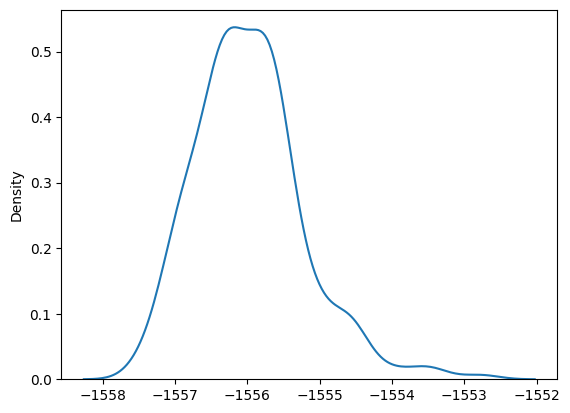

In [17]:
sns.kdeplot(y_pertrubed)

## Perturbation

In [18]:
simulation_count = 200
perturbation_results = []
const_lowest_energy = np.full(simulation_count, lowest_energy_pred)

for method, scale in tqdm(list(itertools.product([0, 1], np.linspace(0.001, 0.1, 50)))):
    rng = np.random.default_rng(21)

    pertrubed_structures = [create_perturbation(stable_structure_path, scale, method, rng) for _ in range(simulation_count)]
    X_pertrubed = soap.create(pertrubed_structures, n_jobs=6)
    y_pertrubed = model.predict(X_pertrubed)

    perturbation_results.append({
        "method": method,
        "scale": scale,
        "mae": mean_absolute_error(const_lowest_energy, y_pertrubed),
        "rmse": root_mean_squared_error(const_lowest_energy, y_pertrubed),
    })

100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


In [19]:
df_results = pd.DataFrame(perturbation_results)
df_results.to_csv("../data/petrutbation.csv", index=None)

df_results.head()

,method,scale,mae,rmse
0,0,0.001000,0.061802,0.102909
1,0,0.003020,0.084089,0.119731
2,0,0.005041,0.098319,0.138507
3,0,0.007061,0.103687,0.145336
4,0,0.009082,0.107263,0.151078


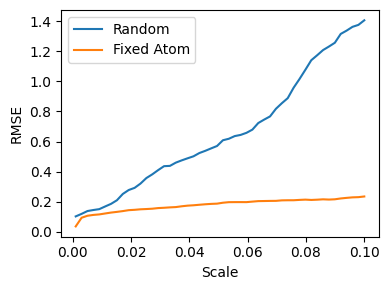

In [20]:
fig, ax = plt.subplots(figsize=(4, 3))

scoring = "rmse"

ax.plot(df_results["scale"][df_results["method"] == 0], df_results[scoring][df_results["method"] == 0], label="Random")
ax.plot(df_results["scale"][df_results["method"] == 1], df_results[scoring][df_results["method"] == 1], label="Fixed Atom")
ax.legend()
ax.set_ylabel(scoring.upper())
ax.set_xlabel("Scale")

fig.tight_layout()
plt.show()

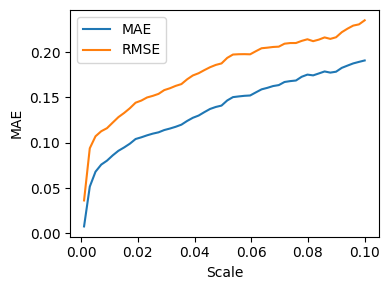

In [26]:
fig, ax = plt.subplots(figsize=(4, 3))

method = 1

ax.plot(df_results["scale"][df_results["method"] == method], df_results["mae"][df_results["method"] == method], label="MAE")
ax.plot(df_results["scale"][df_results["method"] == method], df_results["rmse"][df_results["method"] == method], label="RMSE")
ax.legend()
ax.set_ylabel(scoring.upper())
ax.set_xlabel("Scale")

fig.tight_layout()
plt.show()